# Machine learning

Ramannoodle includes a brand-new machine learning model for predicting polarizabilities. This model uses a graph neural network architecture. The tutorial will demonstrate how to initialize, train, and evaluate this model. This notebook is available on [Github](https://github.com/wolearyc/ramannoodle/blob/main/docs/source/notebooks/machine-learning.ipynb).  

First, some setup.

In [24]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('png')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["mathtext.default"] = 'regular'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['lines.linewidth'] = 1.5

## Constructing the polarizability model

Our final goal is to calculate TiO2's Raman spectrum. 

#### Datasets

First, we will load in a training and validation set. These datasets (which are not publicly available) consist of polarizability calculations carried out on a variety of molecular dynamics snapshots. 

In [39]:
import ramannoodle.io.vasp as vasp_io
import glob

# This data is not publicly available. Sorry! 
training_set = vasp_io.outcar.read_polarizability_dataset(
    list(glob.glob("/Volumes/Untitled/TiO2_eps/train/*ps*/scratch/OUTCAR"))
)
validation_set = vasp_io.outcar.read_polarizability_dataset(
    list(glob.glob("/Volumes/Untitled/TiO2_eps/validation/*ps*/scratch/OUTCAR"))
)
# As is best practice, we scale the validation set with respect to the training set.
validation_set.scale_polarizabilities(
    training_set.mean_polarizability, training_set.stddev_polarizability
)

print("Training set size:", len(training_set), "structures")
print("Validation set size:", len(validation_set), "structures")

100%|██████████| 100/100 [00:00<00:00, 120.69 files/s]

Training set size: 99 structures
Validation set size: 100 structures


Let's plot the training set.

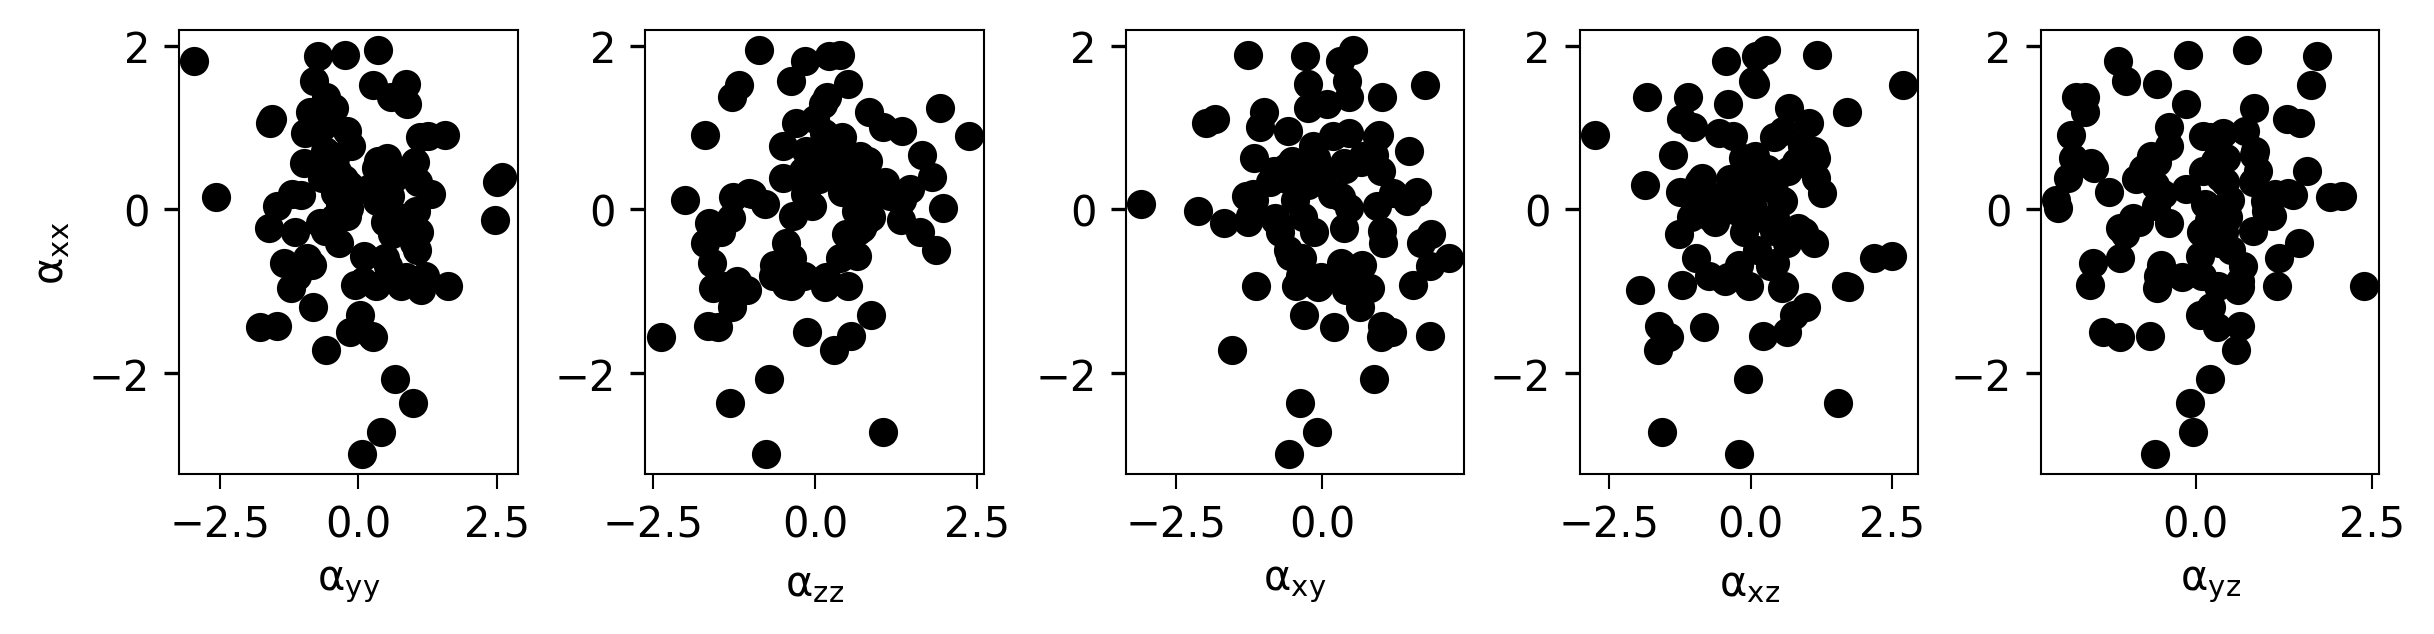

In [40]:
from torch.utils.data import DataLoader

fig = plt.figure(constrained_layout=True, figsize=(8, 2))
gs = fig.add_gridspec(1, 5, wspace=0)
axes = gs.subplots()
loader = DataLoader(training_set, batch_size = 100)

subscripts = ["xx","yy","zz","xy","xz","yz"]
for lattice, atomic_numbers, positions, true_polarizability  in loader:
    for i in range(5): 
        axis = axes[i]  # type: ignore
        axis.scatter(true_polarizability[:,i+1].cpu(), true_polarizability[:,0].cpu(), color="black")
        axis.set_xlabel(r"$\alpha_{" + subscripts[i+1] + "}$")
        if i == 0:
            axis.set_ylabel(r"$\alpha_{" + subscripts[0] + "}$")

Note that the dataset internally standard-scales each independent element of the polarizability tensor. 

### Model initialization

With the dataset loaded, we can initialize the model by specifying a reference structure, several hyperparameters, as well as the mean/standardization used to scale the dataset.

In [48]:
import torch
from ramannoodle.pmodel.torch.gnn import PotGNN
ref_structure = vasp_io.poscar.read_ref_structure("../../../test/data/TiO2/POSCAR")

model = PotGNN(
    ref_structure,
    size_node_embedding=5,
    size_edge_embedding=14,
    num_message_passes=4,
    cutoff = 2,
    gaussian_filter_start=0,
    gaussian_filter_end=5,
    mean_polarizability=training_set.mean_polarizability,
    stddev_polarizability=training_set.stddev_polarizability
)

# Recommended initialization for weights and biases.
def init_biases(m):
    if isinstance(m,torch.nn.Linear):
        torch.nn.init.uniform_(m.bias,-0.5,0.5)
def init_weights(m):
    if isinstance(m,torch.nn.Linear) or isinstance(m,torch.nn.Embedding):
        torch.nn.init.normal_(m.weight, mean = 0, std = 1)

model = model.apply(init_biases)
model = model.apply(init_weights)

In the first stage of training, we use a fairly large learning rate and a relatively small batch size. During this training, we expect the training loss to decrease fairly nicely. Validation loss will be extremely noisy (due to batch normalization within the model), while the variance of the validation predictions will approach 1 for each polarizability component.

In [49]:
from ramannoodle.pmodel.torch.train import train_single_epoch

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

from tqdm import trange
with trange(100) as t:
    for epoch in t:
        training_loss, validation_loss, validation_var = train_single_epoch(
            model, training_set, validation_set, 5, optimizer, loss_function
        )
        t.set_postfix(
            training_loss=training_loss, 
            validation_loss=validation_loss, 
            validation_var=np.array2string(validation_var, precision = 2)
        )
        if training_loss < 0.15:
            break 


 85%|████████▌ | 85/100 [01:09<00:12,  1.22it/s, training_loss=0.147, validation_loss=106, validation_var=[1.31 0.6  0.33 1.49 0.81 0.7 ]]                        


We halt training once the training loss goes below 0.150. However, the validation loss is extremely high. In the second stage of training, we turn down the learning rate to stabilize the batch normalization term (and therefore stabilize the validation loss).

In [50]:
from ramannoodle.pmodel.torch.train import train_single_epoch

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

from tqdm import trange
with trange(100) as t:
    for epoch in t:
        training_loss, validation_loss, validation_var = train_single_epoch(
            model, training_set, validation_set, 5, optimizer, loss_function
        )
        t.set_postfix(
            training_loss=training_loss, 
            validation_loss=validation_loss, 
            validation_var=np.array2string(validation_var, precision = 2)
        )
        if validation_loss < 0.165:
            break 


 24%|██▍       | 24/100 [00:17<00:56,  1.34it/s, training_loss=0.124, validation_loss=0.164, validation_var=[0.78 1.16 0.68 0.77 1.17 0.83]]


Now that the model has been roughly trained, we can visualize it's performance.

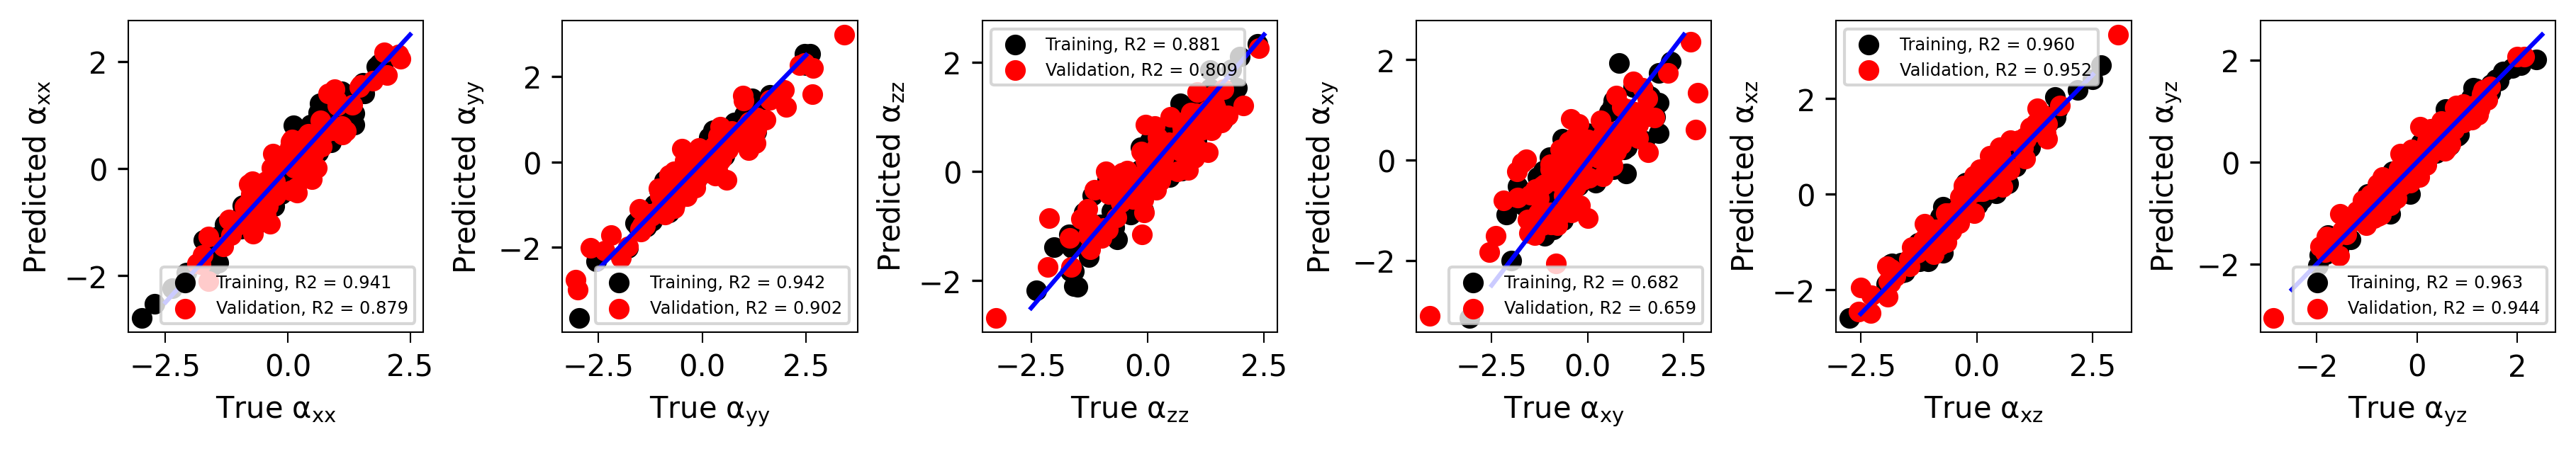

In [51]:
import torcheval
import torcheval.metrics

fig = plt.figure(constrained_layout=True, figsize=(12, 2))
gs = fig.add_gridspec(1, 6, wspace=0)
axes = gs.subplots()
plot_train_loader = DataLoader(training_set, batch_size = 100)
plot_validation_loader = DataLoader(validation_set, batch_size = 100)

model.eval()

subscripts = ["xx","yy","zz","xy","xz","yz"]
for i in range(6): 
    axis = axes[i]  # type: ignore
    for lattice, atomic_numbers, positions, true_polarizability  in plot_train_loader:
        predicted_polarizability = model(lattice, atomic_numbers, positions).detach()
        loss = loss_function(true_polarizability[:,i], predicted_polarizability[:,i])
        metric = torcheval.metrics.R2Score()
        metric.update(predicted_polarizability[:,i], true_polarizability[:,i])
        R2 = metric.compute()
        axis.scatter(
            true_polarizability[:,i], predicted_polarizability[:,i], color="black", 
            label = f"Training, R2 = {R2:.3f}"
        )
    for lattice, atomic_numbers, positions, true_polarizability  in plot_validation_loader:
        predicted_polarizability = model(lattice, atomic_numbers, positions).detach()
        loss = loss_function(true_polarizability[:,i], predicted_polarizability[:,i])
        metric = torcheval.metrics.R2Score()
        metric.update(predicted_polarizability[:,i], true_polarizability[:,i])
        R2 = metric.compute()
        axis.scatter(
            true_polarizability[:,i], predicted_polarizability[:,i], color="red",
            label = f"Validation, R2 = {R2:.3f}"
        )
        
    axis.plot([-2.5,2.5],[-2.5,2.5],color = "blue", zorder = 5)
    axis.set_xlabel(r"True $\alpha_{" + subscripts[i] + "}$")
    axis.set_ylabel(r"Predicted $\alpha_{" + subscripts[i] + "}$")
    l = axis.legend(fontsize ="xx-small")

The model is performing fairly well, though it does struggle somewhat on the zz and xy components. With the model trained, we can use it to compute a Raman spectrum.

### Raman spectrum calculation

In [52]:
from ramannoodle.dynamics.trajectory import Trajectory
import ramannoodle.io.vasp as vasp_io

# This trajectory is not publicly available. Sorry! 
trajectory = vasp_io.vasprun.read_trajectory(
    f"/Volumes/Untitled/md/TiO2/production.xml"
)

In [53]:
# Compute spectrum
spectrum = trajectory.get_raman_spectrum(model)

100%|██████████| 20000/20000 [00:35<00:00, 568.61 configs/s]


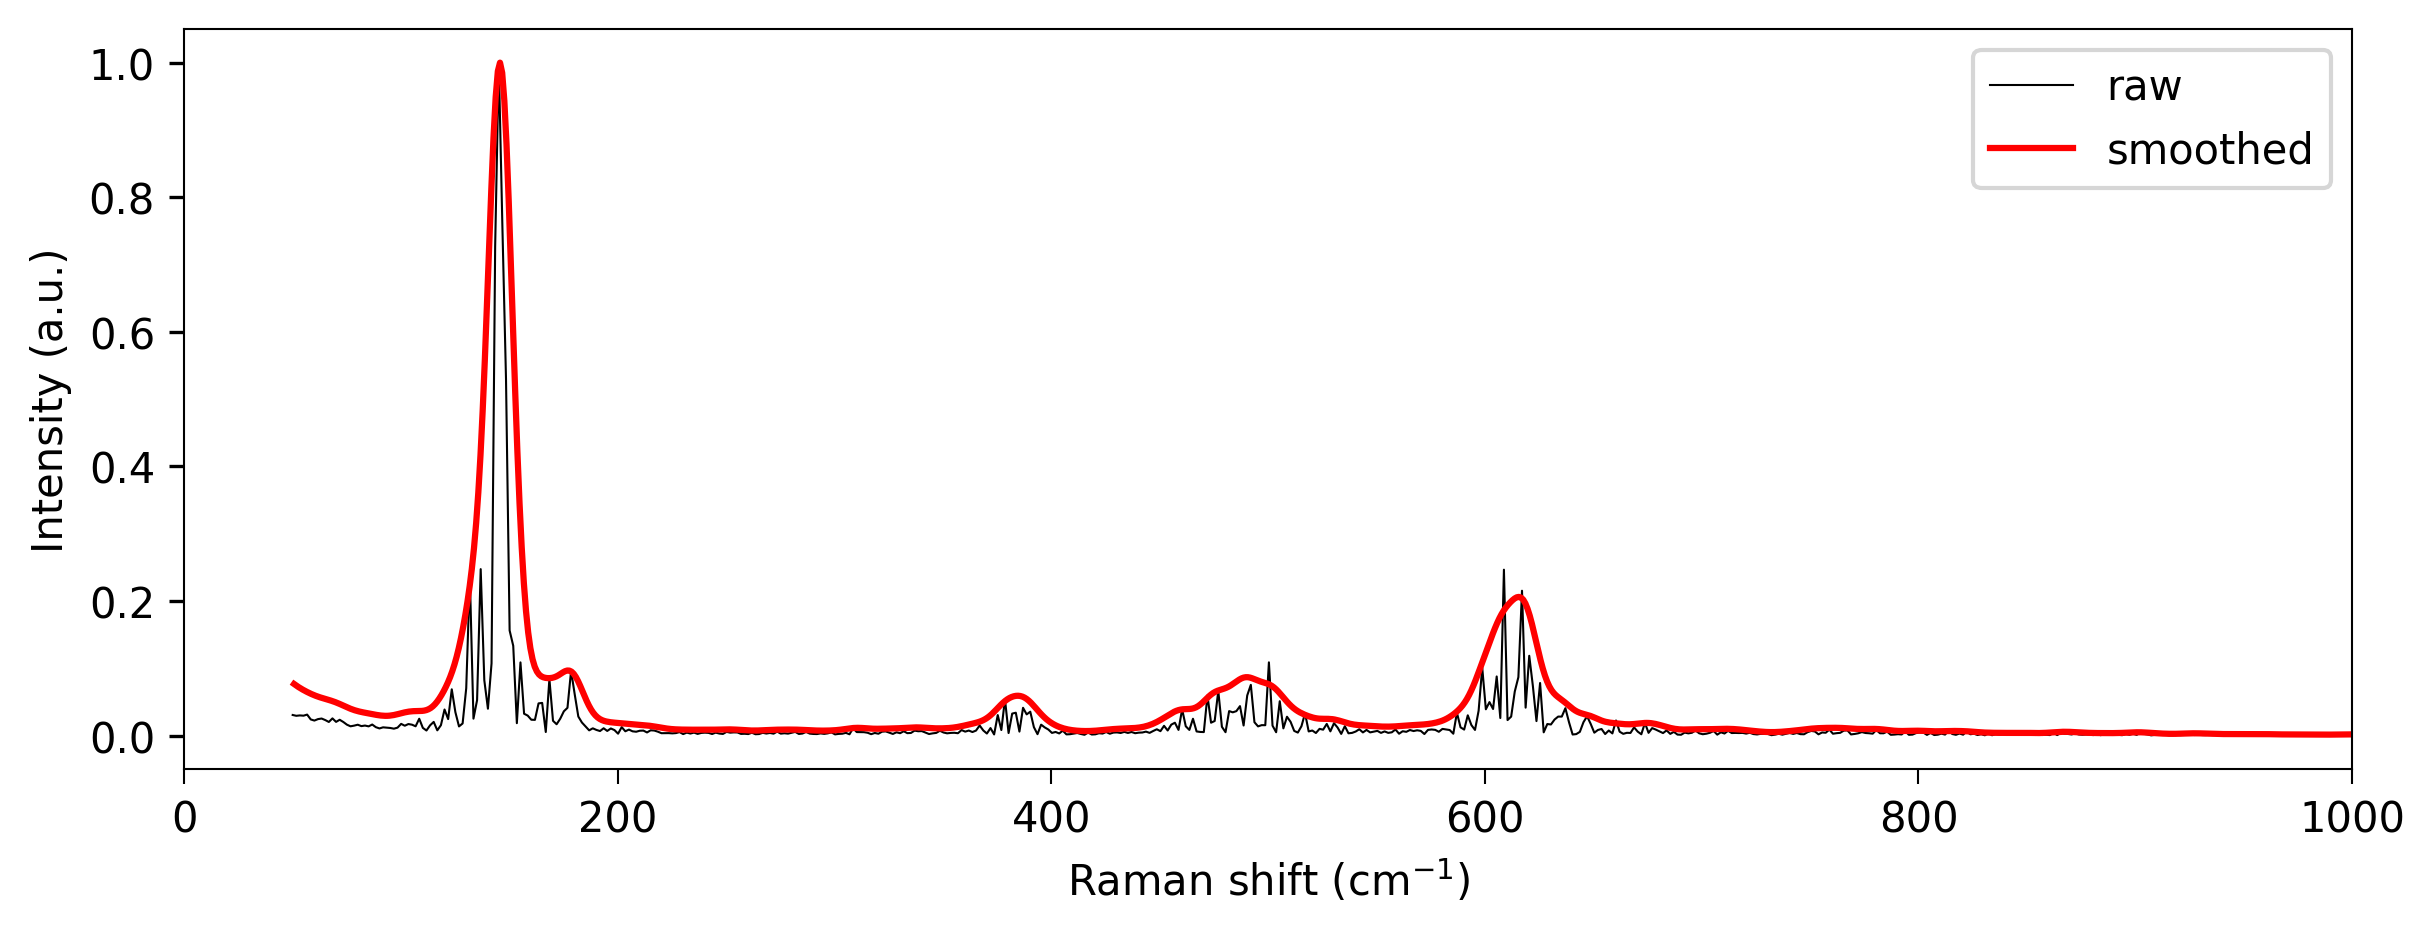

In [54]:
from ramannoodle.spectrum.spectrum_utils import convolve_spectrum

# Then plot
wavenumbers, total_intensities = spectrum.measure(laser_correction = True, 
                                           laser_wavelength = 532, 
                                           bose_einstein_correction = True, 
                                           temperature = 300)

fig = plt.figure(constrained_layout = True, figsize = (8, 3))
axis = fig.add_subplot(111)
lower_cutoff = 50 
axis.plot(
    wavenumbers[wavenumbers > lower_cutoff], 
    total_intensities[wavenumbers > lower_cutoff] / np.max(total_intensities[wavenumbers > lower_cutoff]), 
    label = "raw", color = 'black', linewidth = 0.5
)
wavenumbers, total_intensities = convolve_spectrum(wavenumbers, total_intensities)
axis.plot(
    wavenumbers[wavenumbers > lower_cutoff], 
    total_intensities[wavenumbers > lower_cutoff] / np.max(total_intensities[wavenumbers > lower_cutoff]), 
    label = "smoothed", color = "red"
)

axis.set_xlim((0,1000))
axis.legend()
axis.set_ylabel("Intensity (a.u.)")
l = axis.set_xlabel(r"Raman shift ($\mathregular{cm^{-1}}$)")

This is a excellent spectrum that closely resembles experimental data.